In [60]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from datetime import datetime

tf.compat.v1.disable_eager_execution()

In [61]:
class DQN:
    def __init__(self, env, tau=0.003, gamma=0.99, hidden_size=64, learning_rate=0.0005, batch_size=32):
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.C = 4
        self.memory = deque(maxlen=100000)
        self.count = 0
        
        self.Q, self.target_Q  = self.QNetwork(), self.QNetwork()
    
    def QNetwork(self, state_size=8, action_size=4):
        model = Sequential()
        # we should try different activation function and compare them
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(self.hidden_size, activation="relu"))
        model.add(Dense(action_size))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def memory_append(self, experience):
        self.memory.append(experience)
    
    def action(self, state, epsilon):
        if np.random.random() >= epsilon:
            return np.argmax(self.Q.predict(state)[0])
        else:
            return self.env.action_space.sample()
    
    def train_weight(self):
        weights = self.Q.get_weights()
        target_weights = self.target_Q.get_weights()
        for i, _ in enumerate(weights):
            target_weights[i] = target_weights[i] + self.tau * (weights[i] - target_weights[i])
        self.target_Q.set_weights(target_weights)
        
    def learn(self):
        self.count += 1
        self.count %= self.C
        if len(self.memory) < self.batch_size:
            return None
        batch_state, batch_target = [], []
        sample_batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in sample_batch:
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.amax(self.target_Q.predict(next_state)[0])
            target_val = self.Q.predict(state)
            target_val[0][action] = target

            batch_state.append(state[0])
            batch_target.append(target_val[0])
        self.Q.fit(np.array(batch_state), np.array(batch_target), epochs=1, verbose=0)
        if self.count == 0:
            self.train_weight()
    
    def save(self, file):
        self.Q.save(file)

In [62]:
# Training
def train(gamma=0.99, learning_rate=0.0005, name="test", decay_rate=0.0001, batch_size=32, tau=0.003):
    env = gym.make("LunarLander-v2")
    train_episodes = 2000 
    max_steps = 1000
    epsilon=1.0
    epsilon_stop=0.01
    
    # create a score window to terminate training early
    score = []
    score_moving_window = deque(maxlen=100)
    epsilons = []
    # create the agent
    agent = DQN(env=env, learning_rate=learning_rate, gamma=gamma, batch_size=batch_size, tau=tau)
    
    for episode in range(1, train_episodes):
        total_reward = 0
        step = 0
        state = env.reset().reshape(1, 8)
        epsilons.append(epsilon)
        while step < max_steps:
            step += 1
            
            # use epsilon greedy policy to get action
            action = agent.action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,8])
            total_reward += reward

            # add the transition to replay memory
            agent.memory_append((state, action, reward, next_state, done))
            
            # learn
            agent.learn()
            state = next_state

            if done:
                break
        
        # record score and score window
        score.append(total_reward)
        score_moving_window.append(total_reward)
        # update epsilon
        epsilon = epsilon_stop + (epsilon - epsilon_stop)*np.exp(-decay_rate*step)
        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(total_reward),
              'Mean score: {}'.format(np.mean(score_moving_window)),
              'Explore P: {}'.format(epsilon),
              datetime.now().time())
        if np.mean(score_moving_window) >= 220:
            agent.save(name)
            print("\n Achieve Mean Score of 220 over last 100 episodes with total {} episodes!".format(episode))
            break
    agent.save(name)
    print(print("\n Not achieve Mean Score of 220 over past 100 episodes with total {} episodes!".format(episode)))
    env.close()
    return (score, epsilons)

In [63]:
def test(model):
    env = gym.make("LunarLander-v2")
    score = []
    max_steps = 1000
    for episode in range(100):
        total_reward = 0
        state = env.reset().reshape(1,8)
        step = 0
        while step < max_steps:
            # env.render()
            step += 1
            action = np.argmax(model.predict(state))
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,8])
            total_reward += reward
            state = next_state
            if done:
                break
        score.append(total_reward)
        print('Episode: {}'.format(episode),
              'Total reward: {}'.format(total_reward),
              datetime.now().time())
    env.close()
    return score

In [65]:
model = keras.models.load_model("./models/gamma0.999/")
s = test(model)

Episode: 0 Total reward: 274.91693699722066 23:50:14.400997
Episode: 1 Total reward: 227.62945785689823 23:50:14.853391
Episode: 2 Total reward: 252.86191704962468 23:50:15.193258
Episode: 3 Total reward: 288.2160047150435 23:50:15.586710
Episode: 4 Total reward: 272.67426512597103 23:50:15.916238
Episode: 5 Total reward: 271.84622220514706 23:50:16.262493
Episode: 6 Total reward: 282.4526951797223 23:50:16.592814
Episode: 7 Total reward: 278.79171207645777 23:50:16.870018
Episode: 8 Total reward: 251.525605414721 23:50:17.272475
Episode: 9 Total reward: 239.87978789348168 23:50:17.776380
Episode: 10 Total reward: 241.5531433227346 23:50:18.191203
Episode: 11 Total reward: 258.3095454387129 23:50:18.481745
Episode: 12 Total reward: 276.8938735365613 23:50:18.806651
Episode: 13 Total reward: 182.346849953893 23:50:19.746442
Episode: 14 Total reward: 259.76249982169213 23:50:20.080532
Episode: 15 Total reward: 269.12324870112417 23:50:20.406888
Episode: 16 Total reward: 297.9726547405785

In [66]:
np.mean(s)

227.12143211529846

Text(0, 0.5, 'Score')

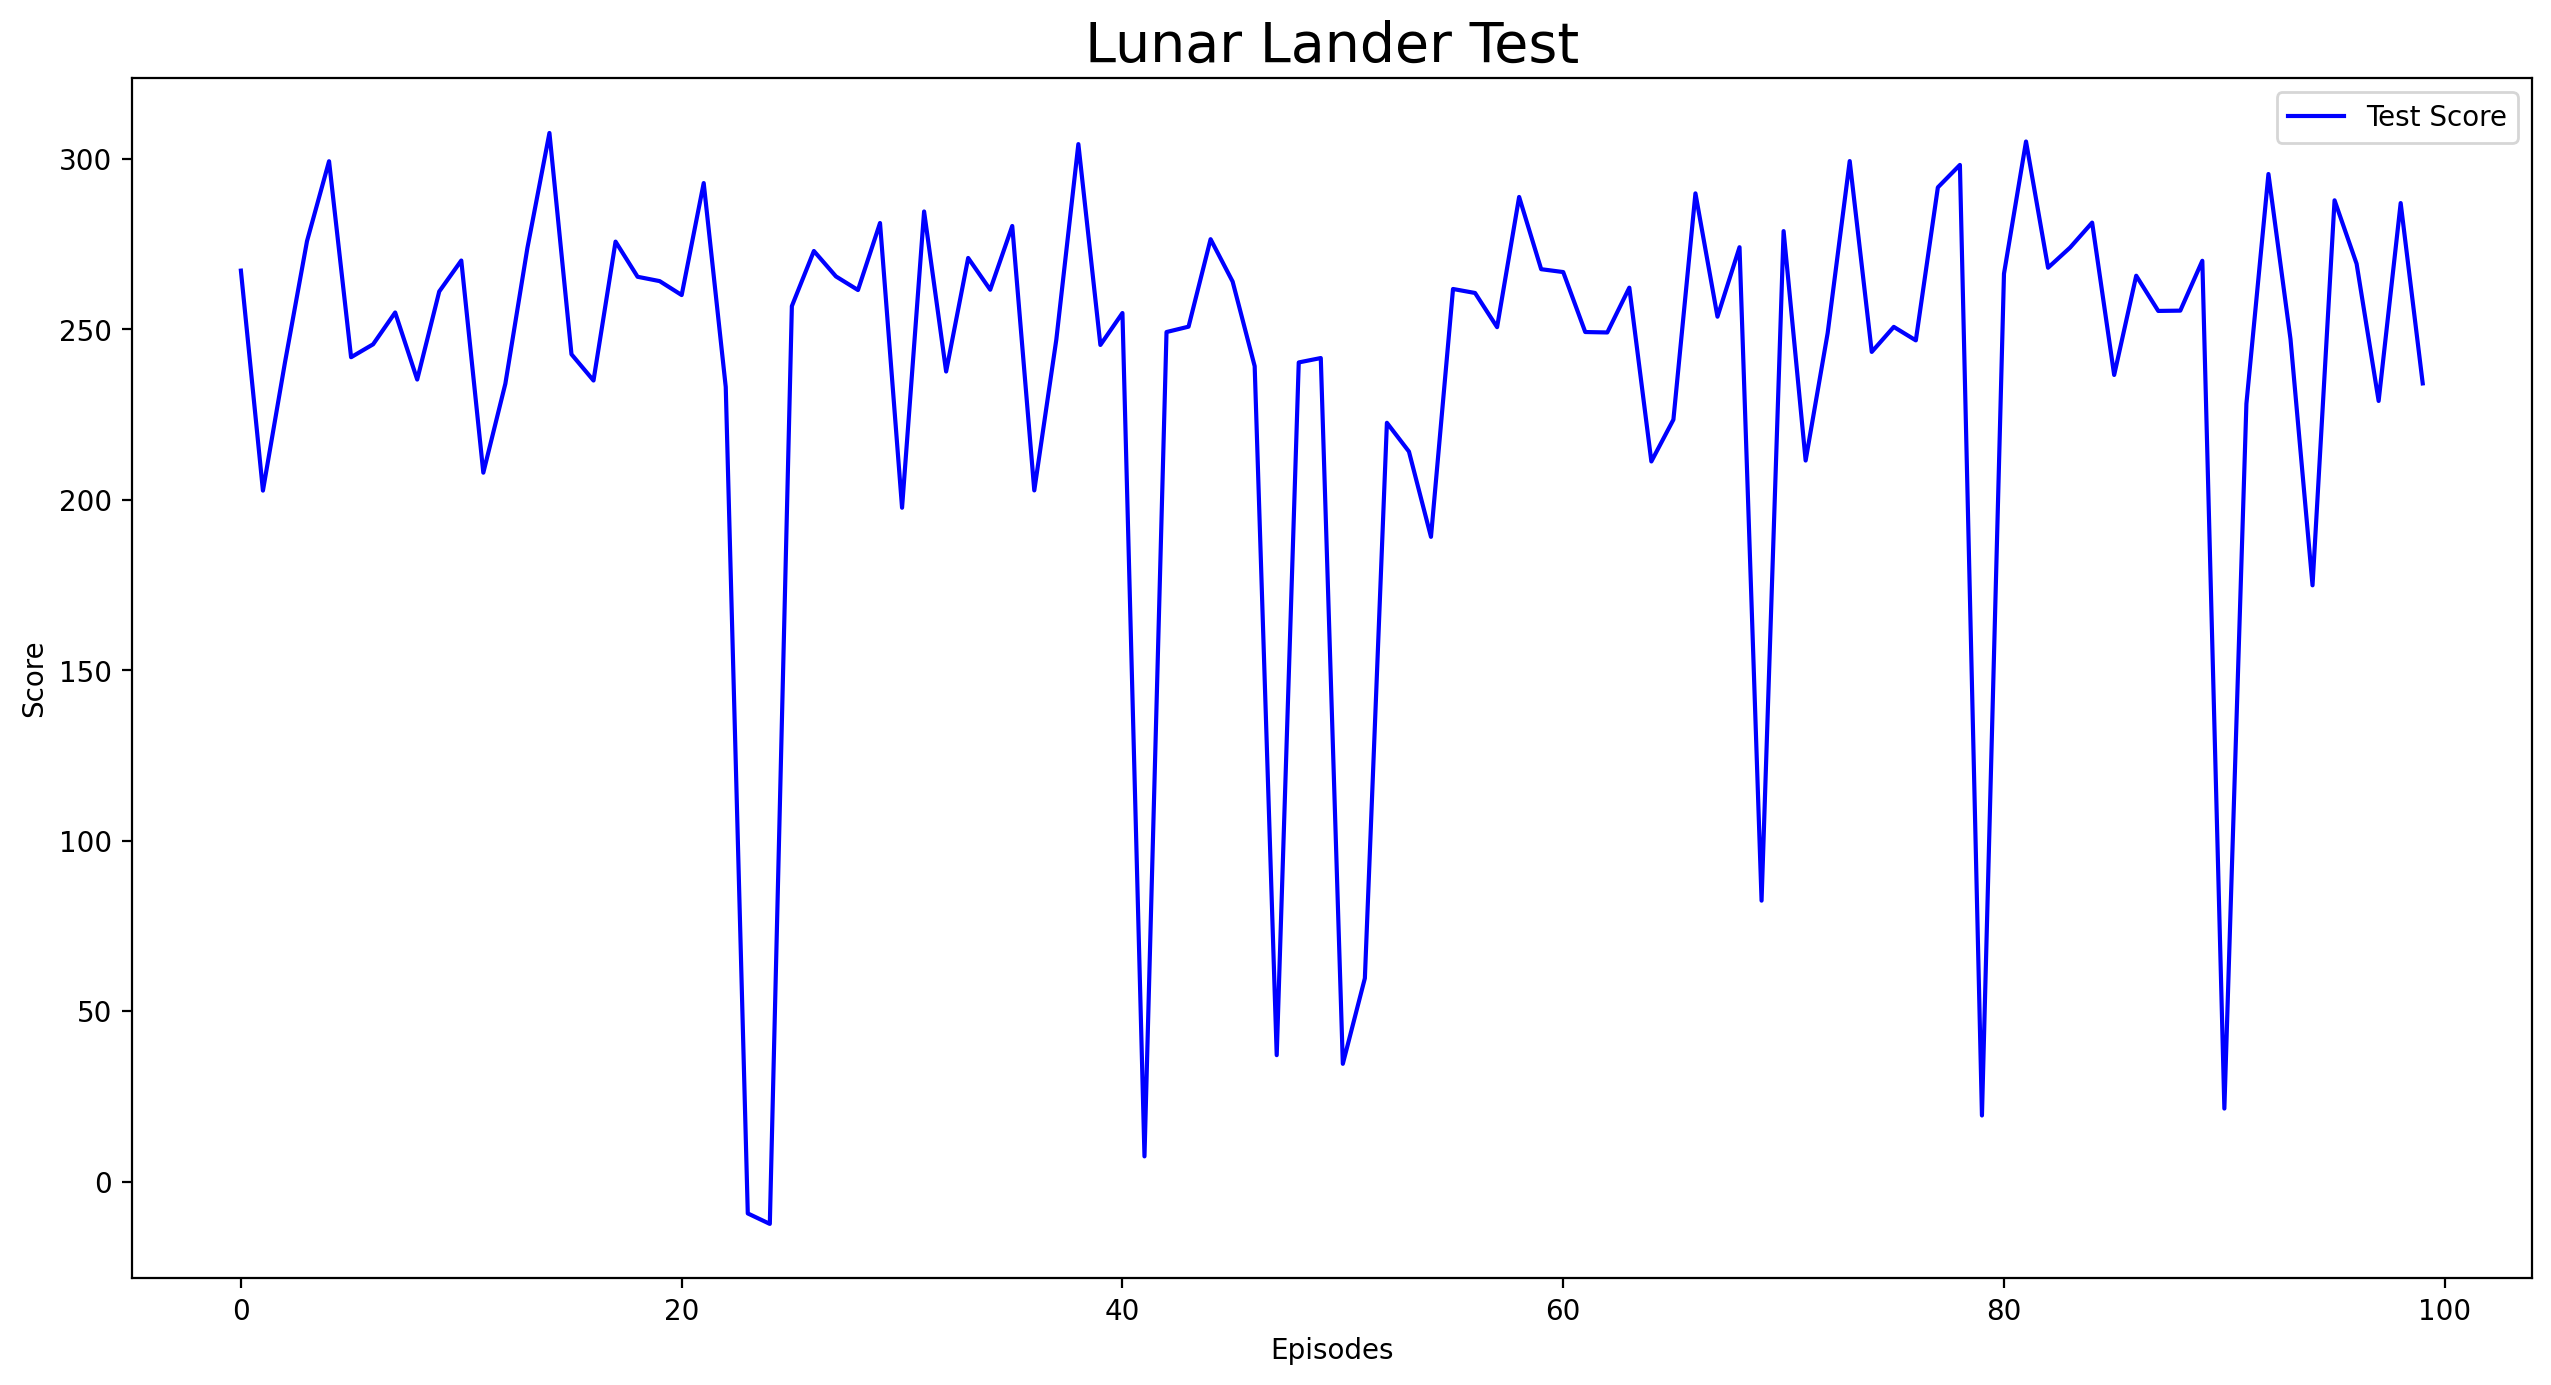

In [44]:
fig=plt.figure(figsize=(12,6),dpi=200)
ax=fig.add_axes([0,0,1,1])
lrs005=ax.plot(s,'b',label="Test Score")
ax.legend(loc=0)
ax.set_title("Lunar Lander Test",size=20)
ax.set_xlabel("Episodes")
ax.set_ylabel("Score")

In [73]:
epsilon1=pd.read_csv("./scores/epsilons_decay_rate0.0005")["0"]
epsilon2=pd.read_csv("./scores/epsilons_decay_rate0.0001")["0"]
epsilon3=pd.read_csv("./scores/epsilons_decay_rate5e-05")["0"]
epsilon4=pd.read_csv("./scores/epsilons_decay_rate5e-06")["0"]

Text(0, 0.5, 'Epsilon')

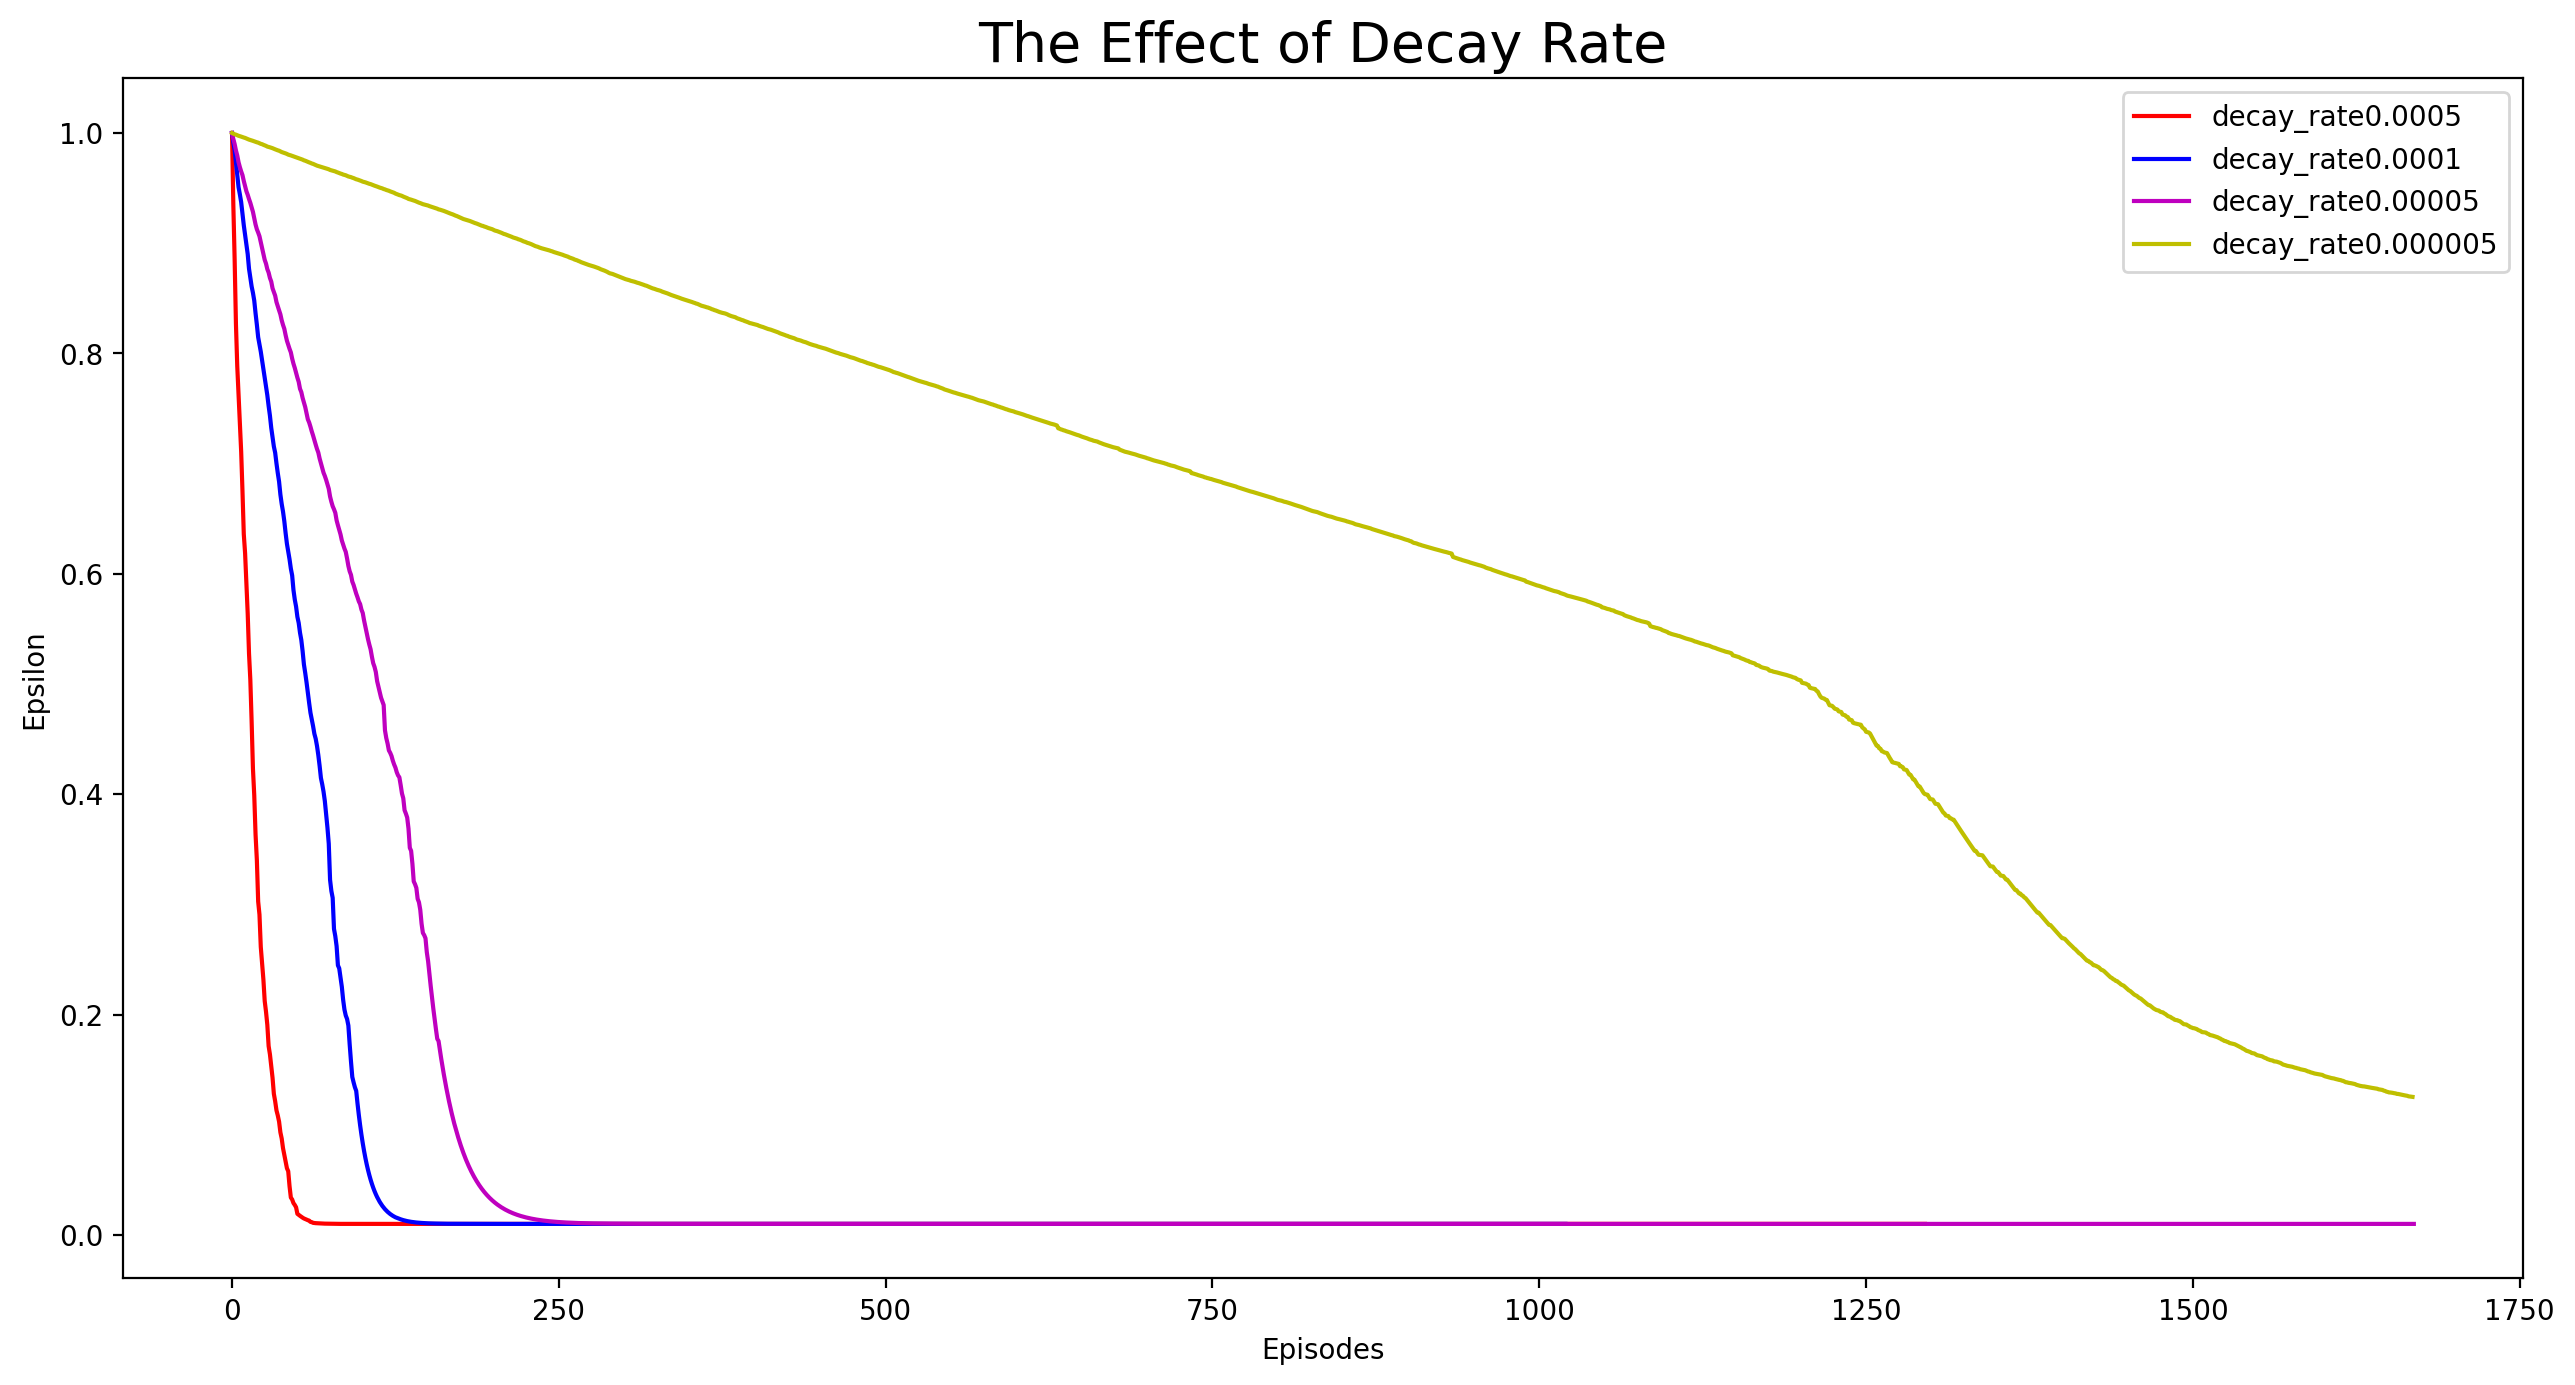

In [75]:
fig=plt.figure(figsize=(12,6),dpi=200)
ax=fig.add_axes([0,0,1,1])
decay_rate0005=ax.plot(epsilon1,'r',label='decay_rate0.0005',alpha=1)
decay_rate0001=ax.plot(epsilon2,'b',label='decay_rate0.0001',alpha=1)
decay_rate00005=ax.plot(epsilon3,'m',label='decay_rate0.00005',alpha=1)
decay_rate000005=ax.plot(epsilon4,'y',label='decay_rate0.000005',alpha=1)
ax.legend(loc=0)
ax.set_title("The Effect of Decay Rate",size=20)
ax.set_xlabel("Episodes")
ax.set_ylabel("Epsilon")